Hey

In [5]:
import pandas as pd
import lightgbm as ltb
import numpy as np
import re


from scipy.stats import linregress
import scipy.linalg

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5



In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)

In [ ]:
#MY COMPUTER

#READING INITIAL TRAIN DATA
# data_traff_train = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/train/hash_school_dpi_model_traff.sas7bdat')
# data_train = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/train/hash_school_dpi_model_fe.sas7bdat')

#READING INITIAL TEST DATA
# data_traff_test = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/test/hash_school_dpi_model_traff_test.sas7bdat')
# data_test = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/test/hash_school_dpi_model_fe_test.sas7bdat')
# data_test2 = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/test/hash_school_dpi_model_test.sas7bdat')


#WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# data_train.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/train/data_train.parquet.gzip',compression='gzip')
# data_test.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/test/data_test.parquet.gzip',compression='gzip')

# # READING INITIAL TRAIN AND TEST DATA FROM PARQUET
data_train = pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/train/data_train.parquet.gzip')
data_test = pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/test/data_test.parquet.gzip')


In [4]:
# ED'S COMPUTER

# READING INITIAL TRAIN DATA
# data_traff_train = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/train/hash_school_dpi_model_traff.sas7bdat')
# data_train = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/train/hash_school_dpi_model_fe.sas7bdat')

#WRITING INITIAL TRAIN DATA TO PARQUET
# data_traff.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/train/hash_school_dpi_model_traff.parquet.gzip',compression='gzip')
# 

# READING INITIAL TEST DATA
# data_traff_test = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/test/hash_school_dpi_model_traff_test.sas7bdat')
# data_test = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/test/hash_school_dpi_model_fe_test.sas7bdat')
# data_test2 = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/test/hash_school_dpi_model_test.sas7bdat')

#WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# data_train.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/train/data_train.parquet.gzip',compression='gzip')
# data_test.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/test/data_test.parquet.gzip',compression='gzip')

# READING INITIAL TRAIN AND TEST DATA FROM PARQUET
data_train= pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/train/data_train.parquet.gzip')
data_test = pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/test/data_test.parquet.gzip')


data_train = data_train.astype('float32')
data_test = data_test.astype('float32')


In [ ]:
#DUPLICATES CLEANING AND MERGING INITIAL DATA FILES

# print(data_train.shape)
# print(data_traff_train.shape)
# data_traff_train = data_traff_train.drop_duplicates()
# data_train = data_train.drop_duplicates()
# print(data_train.shape)
# print(data_traff_train.shape)

# data_train = data_train.merge(data_traff_train, on = 'abon_id')
# del data_traff_train

# print(data_test.shape)
# print(data_test2.shape)
# print(data_traff_test.shape)
# data_test = data_test.drop_duplicates()
# data_test2 = data_test2.drop_duplicates()
# data_traff_test = data_traff_test.drop_duplicates()
# print(data_test.shape)
# print(data_test2.shape)
# print(data_traff_test.shape)

# data_test = data_test.merge(data_test2, on = 'abon_id').merge(data_traff_test, on = 'abon_id')
# del data_test2
# del data_traff_test


In [6]:
#Marking categorical columns

def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list


In [7]:
cat_num_col_list = find_cat_cols(data_train)
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

traffic_cols = ['traff_m5', 'traff_m3','traff_m2','traff_m1']

32
879


In [7]:
# data_train_num = data_train[num_col_list]
# data_test_num = data_test[num_col_list]

In [11]:
# # CALCULATION OF TRAFFIC VARIANCE AND LIN.REGR. SLOPE FOR EACH OBSERVATION

# data_train_num = data_train_num.assign(var = data_train_num[traffic_cols].apply(lambda x: x.var(), axis=1))
# data_train_num = data_train_num.assign(var_quant = pd.qcut(data_train_num['var'], 10,labels = False))

# data_test_num = data_test_num.assign(var = data_test_num[traffic_cols].apply(lambda x: x.var(), axis=1))
# data_test_num = data_test_num.assign(var_quant = pd.qcut(data_test_num['var'], 10,labels = False))

# enum = np.arange(1, len(traffic_cols)+1, 1)
# data_train_num = data_train_num.assign(slope_traff = data_train_num.apply(lambda x: linregress(enum, 
#                                                                                                x[traffic_cols]).slope, 
#                                                                           axis=1))

# data_test_num = data_test_num.assign(slope_traff = data_test_num.apply(lambda x: linregress(enum, 
#                                                                                             x[traffic_cols]).slope, 
#                                                                        axis=1))


In [13]:
# WRITING TRAIN AND TEST DATA WITH VARIANCE AND QUANTILES TO PARQUET

#MY COMPUTER
data_train_num.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num.parquet.gzip',compression='gzip')
data_test_num.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_test_num.parquet.gzip',compression='gzip')

#ED's COMPUTER
# data_train_num.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num.parquet.gzip',compression='gzip')
# data_test_num.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_test_num.parquet.gzip',compression='gzip')


In [8]:
# READING TRAIN AND TEST DATA WITH VARIANCE AND QUANTILES FROM PARQUET

#MY COMPUTER
# data_train_num= pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num.parquet.gzip')
# data_test_num= pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_test_num.parquet.gzip')

#ED's COMPUTER
data_train_num= pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num.parquet.gzip')
data_test_num= pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_test_num.parquet.gzip')

data_train_num = data_train_num.astype('float32')
data_test_num = data_test_num.astype('float32')

In [8]:
def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask        
        
# # test = pd.DataFrame(data = np.array([1,2,5,100,2,5,1000]), columns = ['test'])
# # mark_outliers(test, test)

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [ ]:
# data_train_num_outliers_mask = mark_outliers(data_train_num)
# data_train_num_info = df_info(data_train_num, data_train_num_outliers_mask)
# del data_train_num_outliers_mask

In [ ]:
# data_train_num_corr = data_train_num.corr()

In [ ]:
# WRITING DATA_TRAIN_NUM CORRELATION TO PARQUET

#MY COMPUTER
# data_train_num_corr.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num_corr.parquet.gzip',compression='gzip')

#ED's COMPUTER
# data_train_num_corr.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num_corr.parquet.gzip',compression='gzip')


In [9]:
# READING DATA_TRAIN_NUM CORRELATION FROM PARQUET

#MY COMPUTER
# data_train_num_corr = pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num_corr.parquet.gzip')

#ED's COMPUTER
data_train_num_corr = pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num_corr.parquet.gzip')


In [ ]:
# WRITING TRAIN DATA INFO DF TO PARQUET

#MY COMPUTER
# data_train_num_info.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num.parquet.gzip',compression='gzip')

#ED's COMPUTER
# data_train_num_info.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num_info.parquet.gzip',compression='gzip')


In [10]:
# READING TRAIN DATA INFO DF FRFOM PARQUET

#MY COMPUTER
# data_train_num_info = pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num_info.parquet.gzip')

#ED's COMPUTER
data_train_num_info = pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num_info.parquet.gzip')


In [13]:
data_train_num_info = data_train_num_info.merge(data_train_num_corr['target'], left_on='col', right_index=True)

In [10]:
def highlight_p75(s):
    '''
    highlight the maximum in a Series.
    '''
    is_max = s >= s.quantile(0.75)
    return ['background-color: salmon' if v else '' for v in is_max]

In [ ]:
data_train_num_info_style = data_train_num_info.sort_values(by = '%nans', ascending=False).\
                                                style.apply(highlight_p75,
                                                            subset=['%outliers', '%nans']).\
                                                            format({'%of_fr_univalue': "{:.2%}",
                                                                    '%of_unfr_univalue': "{:.2%}",
                                                                    '%outliers': "{:.2%}",
                                                                    '%nans': "{:.2%}",
                                                                    'target': "{:.2f}"})
data_train_num_info_style

In [ ]:
print(data_train_num_info[data_train_num_info['target'].abs() < 0.2].shape)

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() < 0.2].\
                            sort_values(by = 'target', ascending=False).\
                            style.apply(highlight_p75,
                                        subset=['%outliers', '%nans']).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

In [ ]:
print(data_train_num_info[data_train_num_info['target'].abs() >= 0.2].shape)

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() >= 0.2].\
                            sort_values(by = '%nans', ascending=False).\
                            style.apply(highlight_p75,
                                        subset=['%outliers', '%nans']).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

In [14]:
num_cols_to_use = data_train_num_info[(data_train_num_info['target'].abs() >= 0.2) &\
                                      (data_train_num_info['target'].abs() < 1) &\
                                      (data_train_num_info['%nans'] < 0.6)]['col'].to_list()
len(num_cols_to_use)

54

In [15]:
data_descr = pd.read_csv('C:/Users/Edward/Documents/Appleolga/Final_pro/data_descr.csv', names=['feature', 'descr'])

# data_descr = pd.read_csv('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_descr.csv', names=['feature', 'descr'])

In [16]:
data_train_num_info = pd.merge(data_train_num_info, data_descr, how='left', left_on='col', right_on='feature')
data_train_num_info.loc[data_train_num_info['descr'].isna(), 
                        'descr'] = data_train_num_info.loc[data_train_num_info['descr'].isna(), 'col']

In [17]:
data_train_num_info = data_train_num_info.assign(feature_clear = data_train_num_info['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

data_train_num_info['feature_clear'] = data_train_num_info.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))

data_train_num_info = data_train_num_info.drop('feature', axis =1)

In [18]:
num_cols_to_use = list(data_train_num_info.loc[data_train_num_info['col'].isin(num_cols_to_use)].\
                                       groupby('feature_clear')['col'].max('target').values)


In [137]:
# #num cols to use from previous model
# num_cols_to_use = ['MV_Traf_2G_d_Mb','MV_Traf_3G_d_Mb','MV_Traf_4G_d_Mb','MV_ARPU','MV_ap_4G_d',
#                    'MV_ap_innet_out_v','MV_AP_total','non_accum_internet_vol_max_mnt3','gprs_tar_vol_mea_mnt3',
#                    'data_3g_tar_vol_mea_mnt3','data_3g_tv_cnt_max_mnt1','content_cnt_mea_mnt3',
#                    'clc_no_vas_roam_std_mnt3','all_cnt_mea_mnt3','all_clc_mea_mnt3','dpi_duration',
#                    'dpi_upload','dpi_download','dpi_events','dpi_day_cnt','target',
#                    'traff_m5','traff_m3','traff_m2','traff_m1', 'var_quant']

In [94]:
data_train_num_filtered = data_train_num[num_cols_to_use + ['target']]
data_test_num_filtered = data_test_num[num_cols_to_use + ['target']]


print(data_train_num_filtered.shape)
print(data_test_num_filtered.shape)


# data_train_num_filtered = data_train_num[num_cols_to_use].drop('var_quant', axis= 1).fillna(0)
# data_test_num_filtered = data_test_num[num_cols_to_use].drop('var_quant', axis= 1).fillna(0)

# # copy the data 
# df_min_max_scaled = data_train_num_filtered.copy() 
  
# # apply normalization techniques 
# for column in df_min_max_scaled.columns: 
#     df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / \
#     (df_min_max_scaled[column].max() - df_min_max_scaled[column].min()) 
    
# data_train_num_filtered =  df_min_max_scaled.assign(var_quant = data_train_num['var_quant'],
#                                                    target = data_train_num['target'])

# # copy the data 
# df_min_max_scaled = data_test_num_filtered.copy() 
  
# # apply normalization techniques 
# for column in df_min_max_scaled.columns: 
#     df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / \
#     (df_min_max_scaled[column].max() - df_min_max_scaled[column].min()) 

# data_test_num_filtered =  df_min_max_scaled.assign(var_quant = data_test_num['var_quant'],
#                                                   target = data_test_num['target'])
  

(250017, 26)
(243123, 26)


In [95]:
data_train_cat = data_train[cat_col_list].fillna(0)
data_test_cat = data_test[cat_col_list].fillna(0)

In [96]:
big_var_df_train = data_train_num_filtered[data_train_num_filtered['var_quant'] == 9]
big_var_df_test = data_test_num_filtered[data_test_num_filtered['var_quant'] == 9]

big_var_df_train = big_var_df_train.merge(data_train_cat, how  = 'left', left_index = True, right_index = True)
big_var_df_test = big_var_df_test.merge(data_test_cat, how  = 'left', left_index = True, right_index = True)



In [ ]:
# from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = big_var_df.drop('target', axis =1).fillna(0)

plot_n_clusters = 20
sse = []
for k in range(1, plot_n_clusters+1):
    
        kmeans_batch = MiniBatchKMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10, 
                 max_iter=300, 
                 random_state=1)
        
        kmeans_batch.fit(X_train_big_var)
        sse.append(kmeans_batch.inertia_)

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, plot_n_clusters+1), sse)
plt.xticks(range(1, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared error")
plt.show()

In [97]:
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = big_var_df_train.drop('target', axis =1).fillna(0)
X_test_big_var = big_var_df_test.drop('target', axis =1).fillna(0)

kmeans_batch = MiniBatchKMeans(n_clusters=4, 
            init='k-means++', 
            n_init=10,
            max_iter=300, 
            tol=1e-04,
            random_state=1)


y_kmeans_batch_train = kmeans_batch.fit_predict(X_train_big_var)

y_kmeans_batch_test = kmeans_batch.predict(X_test_big_var)


big_var_df_train = big_var_df_train.assign(cluster = y_kmeans_batch_train)

big_var_df_test = big_var_df_test.assign(cluster = y_kmeans_batch_test)


In [44]:
clust = pd.DataFrame(data = big_var_df_train[big_var_df_train['cluster'] == 1][traffic_cols].\
                     values, columns = traffic_cols)
clust_mean_traf = clust.assign(mean_traf = clust.apply(lambda x: x.mean(), axis = 1))
clust_mean_traf.head()

traff_m5   traff_m3   traff_m2    traff_m1  mean_traf
0   32.900688  51.511494  66.900780   67.741142  54.763527
1  102.272469  52.484955  71.463333   27.869442  63.522549
2   60.998688  72.052444  74.979225  103.646606  77.919243
3   70.454506  85.218987  96.586166   98.344543  87.651047
4   72.835640  86.701889  78.924828  102.359093  85.205368

In [53]:
big_var_df_train.head()

traff_m1   traff_m2   traff_m3   traff_m5  var_quant  dpi_duration  \
index                                                                        
54     46.955223  19.664730  44.743168  37.269791        9.0    15143020.0   
62     60.057148   4.752841   0.001471   1.560038        9.0     1753778.0   
69     31.640066  15.593174  20.945753  33.067924        9.0      767606.0   
71     14.888316   7.089849  36.843994  34.068806        9.0     1488572.0   
107    29.581053   9.849603  24.930279  26.497643        9.0     2452569.0   

       clc_no_vas_roam_std_mnt3  dpi_events  dpi_day_cnt  \
index                                                      
54                     4.096710    493652.0         30.0   
62                     3.908355     95916.0         20.0   
69                     4.199046    142049.0         30.0   
71                     3.450910     77942.0         24.0   
107                    3.914092    208813.0         27.0   

       content_cnt_mea_mnt3  data_3g_tv_cnt_std_mnt1  all_cnt_mea_mnt3  \
index                                                                    
54                 4.777722                 2.166126          5.609472   
62                 2.068970                 1.924592          4.310799   
69                 3.355735                 1.971948          5.201715   
71                 2.823361                 2.930975          5.125451   
107                2.644992                 4.821122          5.872353   

       all_clc_std_mnt3   MV_ARPU  dpi_download    dpi_upload  \
index                                                           
54             4.108233  5.163611  2.003810e+10  1.073657e+09   
62             4.031097  5.067668  4.108993e+09  9.943311e+08   
69             4.219813  5.036567  1.611700e+10  6.195549e+08   
71             3.444632  4.374884  7.266265e+09  3.464035e+08   
107            3.944101  5.005520  9.467444e+09  1.108486e+09   

       data_3g_tar_vol_std_mnt3  non_accum_internet_vol_std_mnt3  \
index                                                              
54                    15.262677                        15.261930   
62                    13.296153                        15.865116   
69                    14.021742                        15.214896   
71                    12.867007                        15.227513   
107                   14.908479                        14.909332   

       gprs_tar_vol_std_mnt3  MV_ap_4G_d  MV_ap_innet_out_v  MV_AP_total  \
index                                                                      
54                 13.268003    4.937041           0.064872     4.951520   
62                 13.918247    4.829828           0.069181     4.840164   
69                 12.718163    4.969790           0.066976     4.984273   
71                 12.955087    4.330022           0.163164     4.374884   
107                 8.184277    4.829828           0.069181     4.840163   

       MV_Traf_2G_d_Mb  MV_Traf_3G_d_Mb  MV_Traf_4G_d_Mb     target  \
index                                                                 
54            6.294816         9.863204         0.000000   8.734424   
62            5.540812         2.940440         8.449128  35.088863   
69            5.031644         4.740373         9.662013  13.377264   
71            6.406988         3.834605         8.941500  44.826412   
107           0.005780         9.260653         0.000000   0.000000   

       device_brand_samsung  device_brand_nokia  device_brand_lenovo  \
index                                                                  
54                      0.0                 0.0                  0.0   
62                      1.0                 0.0                  0.0   
69                      1.0                 0.0                  0.0   
71                      0.0                 0.0                  1.0   
107                     0.0                 0.0                  0.0   

       device_brand_apple  device_brand_huawei  devi

In [22]:
def dim_red_pca(X, d=0, corr=False):
    r"""
    Performs principal component analysis.

    Parameters
    ----------
    X : array, (n, d)
        Original observations (n observations, d features)

    d : int
        Number of principal components (default is ``0`` => all components).

    corr : bool
        If true, the PCA is performed based on the correlation matrix.

    Notes
    -----
    Always all eigenvalues and eigenvectors are returned,
    independently of the desired number of components ``d``.

    Returns
    -------
    Xred : array, (n, m or d)
        Reduced data matrix
    
    e_values : array, (m)
        The eigenvalues, sorted in descending manner.

    e_vectors : array, (n, m)
        The eigenvectors, sorted corresponding to eigenvalues.

    """
    # Center to average
    X_ = X-X.mean(0)
    # Compute correlation / covarianz matrix
    if corr:
        CO = np.corrcoef(X_.T)
    else:
        CO = np.cov(X_.T)
    # Compute eigenvalues and eigenvectors
    e_values, e_vectors = sp.linalg.eigh(CO)

    # Sort the eigenvalues and the eigenvectors descending
    idx = np.argsort(e_values)[::-1]
    e_vectors = e_vectors[:, idx]
    e_values = e_values[idx]
    # Get the number of desired dimensions
    d_e_vecs = e_vectors
    if d > 0:
        d_e_vecs = e_vectors[:, :d]
    else:
        d = None
    # Map principal components to original data
    LIN = np.dot(d_e_vecs, np.dot(d_e_vecs.T, X_.T)).T
    return LIN[:, :d], e_values, e_vectors

In [72]:
print(len(list(range(1, len(SN.columns)))))

len(evecs[0])

57


58

[Text(0, 0.5, 'Weight'), Text(0.5, 0, 'Features')]

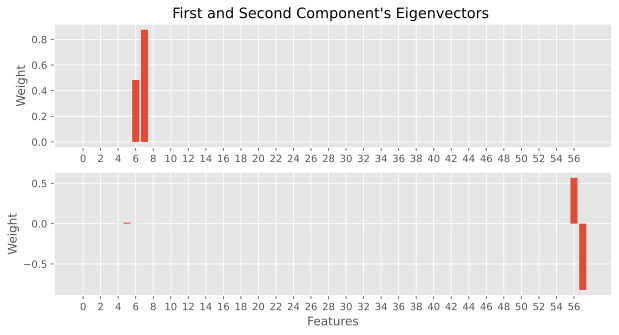

In [59]:
import scipy as sp
from scipy.cluster.vq import kmeans2

SN = big_var_df_train.drop('cluster', axis = 1).fillna(0)
labels_ = y_kmeans_batch_train   

# cluster with 3 random initial clusters
# PCA on orig. dataset 
# Xred will have only 2 columns, the first two princ. comps.
# evals has shape (4,) and evecs (4,4). We need all eigenvalues 
# to determine the portion of variance
Xred, evals, evecs = dim_red_pca(SN,2)   

xlab = '1. PC - ExpVar = {:.2f} %'.format(evals[0]/sum(evals)*100) # determine variance portion
ylab = '2. PC - ExpVar = {:.2f} %'.format(evals[1]/sum(evals)*100)
# plot the clusters, each set separately
    
ax = plt.gca()
scatterHs = []
clr = ['r', 'b', 'k', 'g']
for cluster in set(labels_):
    scatterHs.append(ax.scatter(Xred[labels_ == cluster, 0], Xred[labels_ == cluster, 1], 
                   color=clr[cluster], label='Cluster {}'.format(cluster)))
plt.legend(handles=scatterHs,loc=4)
plt.setp(ax, title='First and Second Principle Components', xlabel=xlab, ylabel=ylab)
# plot also the eigenvectors for deriving the influence of each feature

# plt.figure(figsize = (30,5))
fig, ax = plt.subplots(2,1)

ax[0].bar(list(range(0, len(SN.columns))),evecs[0])
ax[0].set_xticks(range(0, len(SN.columns), 2))
plt.setp(ax[0], title="First and Second Component's Eigenvectors ", ylabel='Weight')


ax[1].bar(list(range(0, len(SN.columns))),evecs[1])
ax[1].set_xticks(range(0, len(SN.columns),2))
plt.setp(ax[1], xlabel='Features', ylabel='Weight')




In [73]:
big_var_df_train.iloc[: , [6,7]].sort_values(by = 'dpi_events', ascending = False)

clc_no_vas_roam_std_mnt3  dpi_events
index                                       
220838                  4.435078  20345340.0
126464                  3.830864   8708482.0
64831                   3.865497   4110961.0
231949                  3.757186   3706988.0
237066                  3.593469   3327167.0
...                          ...         ...
244380                       NaN         NaN
244566                       NaN         NaN
244586                       NaN         NaN
244709                       NaN         NaN
247408                       NaN         NaN

[25002 rows x 2 columns]

In [88]:
Xred[:, 1].shape

(25002,)

In [91]:
big_var_df_train_temp = big_var_df_train.assign(pca1 = Xred[:, 0])
big_var_df_train_temp = big_var_df_train_temp[big_var_df_train_temp['dpi_events'] < 2500000]


In [92]:
big_var_df_train_temp.plot.scatter(x = 'target',
                                   y = 'pca1', 
                                   c = 'cluster', cmap = 'Spectral')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey = True)
fig.subplots_adjust(hspace=0.3)
plt.rcParams.update({'font.size':10})

plot_counter  = [[0,0], [0,1], [1,0],[1,1]]
no_clusters = big_var_df['cluster'].unique()

for cl, i in zip(no_clusters, plot_counter):

    rolling_window = 300

    clust = pd.DataFrame(data = big_var_df[big_var_df['cluster'] == cl][traffic_cols].values, columns = traffic_cols)
    clust_smoothed = clust.rolling(rolling_window, center = True, min_periods=1).mean()
    #     clust_mean_traf = clust.assign(mean_traf = clust.apply(lambda x: x.mean(), axis = 1))
    sns.lineplot(ax=axes[i[0],i[1]], x=clust_smoothed.index, y=clust_smoothed.iloc[: , 0].values)
    sns.lineplot(ax=axes[i[0],i[1]], x=clust_smoothed.index, y=clust_smoothed.iloc[: , 1].values)
    sns.lineplot(ax=axes[i[0],i[1]], x=clust_smoothed.index, y=clust_smoothed.iloc[: , 2].values)
    sns.lineplot(ax=axes[i[0],i[1]], x=clust_smoothed.index, y=clust_smoothed.iloc[: , 3].values)
    axes[i[0],i[1]].set_title('cluster ' + str(cl))



# sns.legend(traffic_cols);


In [ ]:
temp = pd.DataFrame(data = big_var_df[big_var_df['cluster'] == 3]['traff_m5'].values)
temp_smoothed = temp.rolling(200, center = True, min_periods=1).mean()


plt.figure(figsize=(5, 5))
plt.ylabel("traff_m5")
plt.xlabel("instance no")
plt.plot(temp, label="initial")
plt.plot(temp_smoothed, label="smoothed")

plt.legend();

In [ ]:
temp = pd.DataFrame(data = big_var_df[big_var_df['cluster'] == 0]['traff_m5'].values)
temp_smoothed = temp.rolling(200, center = True, min_periods=1).mean()


plt.figure(figsize=(10, 5))
plt.ylabel("traff_m5")
plt.xlabel("instance no")
plt.plot(temp, label="initial")
plt.plot(temp_smoothed, label="smoothed")

plt.legend();

In [ ]:
sns.relplot(data=big_var_df[traffic_cols + ['cluster']], kind="line", col = 'cluster')

In [ ]:
cov = data_train[num_cols_list].cov()
vals, vecs = scipy.linalg.eig(cov)

import decimal

for i, val in enumerate(vals):
    print('var {}: '.format(i+1), decimal.Decimal(val.real))

In [61]:
totals_for_pca = ['MV_ARPU', 'MV_ap_4G_d', 'MV_AP_total','clc_no_vas_roam_std_mnt3']
dpi_for_pca = ['dpi_duration', 'dpi_upload', 'dpi_download', 'dpi_events']

In [62]:
traffic_cols = ['traff_m5', 'traff_m3','traff_m2','traff_m1']
traffic_cols.sort()
traffic_cols_plus_target = ['traff_m5', 'traff_m3','traff_m2','traff_m1', 'target']
traffic_cols_plus_target.sort()

In [ ]:
traffic_cols_plus_target

In [78]:
data_train_num_filtered.columns

Index(['MV_Traf_2G_d_Mb', 'MV_Traf_3G_d_Mb', 'MV_Traf_4G_d_Mb',
       'MV_ap_innet_out_v', 'non_accum_internet_vol_max_mnt3',
       'data_3g_tar_vol_mea_mnt3', 'data_3g_tv_cnt_max_mnt1',
       'content_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'dpi_day_cnt', 'target',
       'traff_m5', 'traff_m3', 'traff_m2', 'traff_m1', 'var_quant', 'var',
       'target'],
      dtype='object')

In [ ]:
data_train_

### TRAIN-TEST

In [98]:
data_train_num_filtered = data_train_num_filtered.fillna(0)
data_test_num_filtered = data_test_num_filtered.fillna(0)


In [99]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[totals_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[totals_for_pca])

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")


In [100]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[dpi_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[dpi_for_pca])

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")

In [101]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[totals_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[totals_for_pca])

pca_train = PCA(n_components = 1, random_state=3)
pca_test = PCA(n_components = 1, random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_test_std)



sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[dpi_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[dpi_for_pca])

pca_train = PCA(n_components = 2, random_state=3)
pca_test = PCA(n_components = 2, random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_test_std)


del(X_train_std, X_test_std)

In [38]:
data_test_model.head()

traff_m1   traff_m2  traff_m3  traff_m5  var_quant  dpi_day_cnt  \
index                                                                     
0       0.019160   0.280629  1.602017  1.034374        4.0         11.0   
1       0.247827   0.318597  0.398598  0.262479        1.0         30.0   
2       0.309305   0.287460  0.244330  0.383596        0.0         30.0   
3      14.961883  10.837551  5.617631  8.286425        8.0         30.0   
4      13.400317  12.273890  6.679313  2.373408        8.0         30.0   

       content_cnt_mea_mnt3  data_3g_tv_cnt_std_mnt1  all_cnt_mea_mnt3  \
index                                                                    
0                  2.957511                 0.693147          4.321923   
1                  2.068970                 1.426062          5.855310   
2                  2.140066                 0.671631          4.416831   
3                  2.866951                 1.118922          6.085069   
4                  2.828299                 1.791759          5.377975   

       all_clc_std_mnt3  data_3g_tar_vol_std_mnt3  \
index                                               
0              3.521201                 12.428873   
1              3.569155                 10.189330   
2              3.741808                  8.859156   
3              3.737594                 11.399608   
4              3.386710                 12.432367   

       non_accum_internet_vol_std_mnt3  gprs_tar_vol_std_mnt3  \
index                                                           
0                            12.412539               7.168998   
1                            10.406885               8.595782   
2                            10.069492               8.659616   
3                            14.073534              13.535685   
4                            13.856974              11.306583   

       MV_ap_innet_out_v  MV_Traf_2G_d_Mb  MV_Traf_3G_d_Mb  MV_Traf_4G_d_Mb  \
index                                                                         
0               0.000000         3.953164         5.468750         0.000000   
1               0.261482         4.010425         5.154093         4.635971   
2               0.750353         4.198070         3.678630         5.547940   
3               0.310149         8.942422         5.774931         7.924137   
4               0.261482         7.852082         5.165080         9.205029   

          target      pca1      pca2      pca3  
index                                           
0       0.001858 -1.338347 -1.073261 -0.150814  
1       0.203970  0.963367 -0.645231  0.200700  
2       0.267894  1.028912 -0.790333  0.090532  
3      21.978195  1.103616  2.296834  1.812925  
4      28.489456  0.891814  1.834457 -0.231622

#### preparing data for modelling

In [102]:
data_train_model = data_train_num_filtered.drop(totals_for_pca, axis=1).fillna(0)
data_train_model = data_train_model.drop(dpi_for_pca, axis=1)
data_train_model = data_train_model.assign(pca1=X_train_pca_totals[:, 0],
                                           pca2=X_train_pca_dpi[:, 0],
                                           pca3=X_train_pca_dpi[:, 1])

data_train_model_varQ90 = data_train_model[data_train_model['var_quant'] == 9]
data_train_model_varQ90 = data_train_model_varQ90.merge(big_var_df_train[cat_col_list + ['cluster']],
                                                       left_index = True, right_index = True)

data_train_model_full = data_train_model
data_train_model = data_train_model[data_train_model['var_quant'] != 9]

data_train_model_varQ90 = data_train_model_varQ90.fillna(0)

In [103]:
data_test_model = data_test_num_filtered.drop(totals_for_pca, axis=1).fillna(0)
data_test_model = data_test_model.drop(dpi_for_pca, axis=1)
data_test_model = data_test_model.assign(pca1=X_test_pca_totals[:, 0],
                                         pca2=X_test_pca_dpi[:, 0],
                                         pca3=X_test_pca_dpi[:, 1])

data_test_model_varQ90 = data_test_model[data_test_model['var_quant'] == 9]
data_test_model_varQ90 = data_test_model_varQ90.merge(big_var_df_test[cat_col_list  + ['cluster']],
                                                      left_index = True, right_index = True)

data_test_model_full = data_test_model
data_test_model = data_test_model[data_test_model['var_quant'] != 9]

data_test_model_varQ90 = data_test_model_varQ90.fillna(0)

In [141]:
# cols_to_use = num_cols_to_use.remove('var_quant')

In [159]:
# data_train_model_full = data_train[num_cols_to_use + ['target']].fillna(0)
# data_test_model_full = data_test[num_cols_to_use+ ['target']].fillna(0)

In [117]:
X, y = data_train_model.loc[:, data_train_model.columns != 'target'], data_train_model.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)

X_full, y_full = data_test_model_full.loc[:, data_test_model_full.columns != 'target'], data_test_model_full.target
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.30, random_state = 17)

X_varQ90 = data_train_model_varQ90.loc[:, data_train_model_varQ90.columns != 'target']
y_varQ90 = data_train_model_varQ90.target
    
X_train_varQ90, X_test_varQ90, y_train_varQ90, y_test_varQ90 = train_test_split(X_varQ90, y_varQ90, 
                                                                                test_size=0.30, random_state = 17)

In [118]:
X_test_test, y_test_test = data_test_model.loc[:, data_test_model.columns != 'target'], data_test_model.target
X_test_test_full = data_test_model_full.loc[:, data_test_model_full.columns != 'target']
y_test_test_full = data_test_model_full.target

X_test_test_varQ90 = data_test_model_varQ90.loc[:, data_test_model_varQ90.columns != 'target']
y_test__test_varQ90 = data_test_model_varQ90.target


In [ ]:
# LINEAR REGRESSION RESULTS


# cols_traff_only = ['traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']
# Train set results

# RMSE train: 8.863683, test: 8.775289
# R^2 train: 0.420902, test: 0.428726

# Test set results

# RMSE test_test: 8.837257
# R^2 test_test: 0.423239


#hight corr target columns, stats chosen by highest correlation with target   
# Train set results



#withou traffic columns with their STD instead



#pca1 and pca2 instead of traffic columns




#ALL DATA NORMALIZED  - BETTER RESULTS, columns = chosen by best target correlation + var_quantiles

# Train set results

# RMSE train: 8.749031, test: 8.664875
# R^2 train: 0.435786, test: 0.443012

# Test set results

# RMSE test_test: 8.723869
# R^2 test_test: 0.437945



#totals_for_pca + dpi_for_pca  = one PCA taken from totals, 2 from dpi



# with traffic variance quantiles, different regression model by quantile 
# Train set results



# with traffic variance quantiles, different regression model by quantile + slope coeff for traffic data

# Train set results



# Test set results



# with traffic variance quantiles, different regression model by quantile + slope coeff for traffic data
#gprs_tar_vol_mea_mnt3 column dropped based on low coefficients 

# Train set results
# RMSE train TOTAL: 8.414630, test TOTAL: 8.452928

# Test set results
# RMSE test TOTAL: 8.711474


    
#Choosing features by regression coefficients did not work out!!!

#with minibatch clustering for vart_quant == 9 dropped to 

# Train set results
# RMSE train TOTAL: 8.410510, test TOTAL: 8.449412

# Test set results
# RMSE test TOTAL: 8.709737





In [106]:
#Regression on all train data 

slr = LinearRegression(normalize=True)

slr.fit(X_train_full, y_train_full)




print('Slope: {:.2f}'.format(slr.coef_[0]))
print('Intercept: {:.2f}'.format(slr.intercept_))

y_train_pred = slr.predict(X_train_full)
y_test_pred = slr.predict(X_test_full)

print()
print('Train set results')
print()
print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))



y_test_test_pred = slr.predict(X_test_test_full)

print()
print('Test set results')
print()
print('RMSE test_test: {:.6f}'.format(
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 test_test: {:.6f}'.format(
        r2_score(y_test_test_full, y_test_test_pred)))

Slope: 0.36
Intercept: -0.50

Train set results

RMSE train: 8.749030, test: 8.664875
R^2 train: 0.435786, test: 0.443012

Test set results

RMSE test_test: 8.723869
R^2 test_test: 0.437945


In [108]:
X_list, y_list = [], []
df_list = []

coeff = []

for g, v in data_train_model.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
#Adding data with 90th qauntile by traffic variance

X_list.append(data_train_model_varQ90.loc[:, data_train_model_varQ90.columns != 'target'])
y_list.append(data_train_model_varQ90.target)  


for i, j in zip(X_list, y_list):
    df_list.append(train_test_split(i, j, test_size=0.30, train_size = 0.70, random_state = 13))
    

y_train_pred, y_test_pred, y_train, y_test = pd.Series(), pd.Series(), pd.Series(), pd.Series()

for X_tr, X_ts, y_tr, y_ts in df_list:
    slr = LinearRegression(normalize=True)

    slr.fit(X_tr, y_tr)
    train_pred = pd.Series(data = slr.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)
#     print(y_train_pred.shape)
    
    test_pred = pd.Series(data = slr.predict(X_ts), index=y_ts.index)
    y_test_pred = y_test_pred.append(test_pred)
    
    y_train = y_train.append(y_tr)
    y_test = y_test.append(y_ts) 
    
    print(str(X_tr['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_tr, train_pred, squared = False),
        mean_squared_error(y_ts, test_pred, squared = False)))
    print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_tr, train_pred),
        r2_score(y_ts, test_pred)))
    print()
    
    coeff.append(slr.coef_)    
    
    joblib_file = "joblib_model"+"_q"+str(X_tr['var_quant'].unique()[0])+".pkl"
    joblib.dump(slr, joblib_file)

print('RMSE train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
mean_squared_error(y_train, y_train_pred, squared = False),
mean_squared_error(y_test, y_test_pred, squared = False)))  

print('R^2 train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
        

0.0 quantile set results

RMSE train: 1.750927, test: 1.882182
R^2 train: 0.021437, test: 0.014518

1.0 quantile set results

RMSE train: 2.015945, test: 1.817837
R^2 train: 0.076708, test: 0.092197

2.0 quantile set results

RMSE train: 2.681640, test: 2.403844
R^2 train: 0.175140, test: 0.104243

3.0 quantile set results

RMSE train: 2.718707, test: 3.193756
R^2 train: 0.234795, test: 0.196933

4.0 quantile set results

RMSE train: 3.748830, test: 3.618744
R^2 train: 0.230396, test: 0.252438

5.0 quantile set results

RMSE train: 4.783059, test: 4.795893
R^2 train: 0.285122, test: 0.290737

6.0 quantile set results

RMSE train: 6.220178, test: 5.801473
R^2 train: 0.321527, test: 0.329883

7.0 quantile set results

RMSE train: 8.230639, test: 8.386583
R^2 train: 0.354039, test: 0.363248

8.0 quantile set results

RMSE train: 11.984496, test: 12.055717
R^2 train: 0.367711, test: 0.351531

9.0 quantile set results

RMSE train: 19.966330, test: 20.141298
R^2 train: 0.280649, test: 0.2536

In [93]:
X_ts

traff_m1  traff_m2  traff_m3  traff_m5  dpi_day_cnt  \
index                                                         
25      0.124364  0.230528  0.146209  0.041306     1.000000   
43      0.082189  0.103333  0.007619  0.010225     1.000000   
150     0.189654  0.078574  0.138989  0.061326     1.000000   
186     0.010471  0.027303  0.076457  0.000246     1.000000   
209     0.069569  0.087893  0.065257  0.004664     0.966667   
...          ...       ...       ...       ...          ...   
242993  0.070197  0.002469  0.000000  0.000000     0.066667   
243009  0.139015  0.172647  0.004380  0.000000     1.000000   
243028  0.151796  0.005281  0.000000  0.000000     0.066667   
243096  0.159410  0.021359  0.000000  0.000000     0.066667   
243121  0.073165  0.007150  0.000000  0.000000     0.066667   

        content_cnt_mea_mnt3  data_3g_tv_cnt_std_mnt1  all_cnt_mea_mnt3  \
index                                                                     
25                  0.350257                 0.192255          0.478294   
43                  0.558531                 0.336343          0.493814   
150                 0.344126                 0.197994          0.523038   
186                 0.348449                 0.281609          0.495291   
209                 0.295423                 0.569449          0.428568   
...                      ...                      ...               ...   
242993              0.403748                 0.244980          0.430313   
243009              0.123020                 0.288139          0.479421   
243028              0.419031                 0.151397          0.410168   
243096              0.085396                 0.000000          0.267394   
243121              0.170793                 0.276479          0.497021   

        all_clc_std_mnt3  data_3g_tar_vol_std_mnt3  \
index                                                
25              0.356947                  0.801090   
43              0.344568                  0.879124   
150             0.402341                  0.846372   
186             0.378629                  0.765776   
209             0.373544                  0.822691   
...                  ...                       ...   
242993          0.000000                  0.757408   
243009          0.435639                  0.816845   
243028          0.187735                  0.800385   
243096          0.443032                  0.000000   
243121          0.479560                  0.676439   

        non_accum_internet_vol_std_mnt3  gprs_tar_vol_std_mnt3  \
index                                                            
25                             0.853552               0.882223   
43                             0.838363               0.766552   
150                            0.856028               0.844478   
186                            0.841132               0.862780   
209                            0.831698               0.632191   
...                                 ...                    ...   
242993                         0.786279               0.667177   
243009                         0.865678               0.875811   
243028                         0.790274               0.000000   
243096                         0.828466               0.000000   
243121                         0.785786               0.696425   

        MV_ap_innet_out_v  MV_Traf_2G_d_Mb  MV_Traf_3G_d_Mb  MV_Traf_4G_d_Mb  \
index                                                                          
25               0.027592         0.838245         0.752664         0.834912   
43               0.071391         0.622224         0.835717         0.000000   
150              0.018286         0.771665         0.770237         0.651488   
186              0.027592         0.433249         0.511752         0.702543   
209              0.018286         0.683123         0.733945         0.755007   
...                   ...              ...              ...              ...   
242993    

In [ ]:
df_coeff= pd.DataFrame()

for i in coeff:
    
    df_coeff= df_coeff.append(pd.Series(i), ignore_index = True)

df_coeff.columns = X_train.columns

def abs_more_than_0_02(value): 
    
    if abs(value) > 0.02:
        color = 'green'
    else:
        color = 'red'
        
    return 'color: %s' % color
    

df_coeff.T.style.applymap(abs_more_than_0_02)


In [ ]:
feature_list_by_var_quantile = []
df_coeff = df_coeff.T
for col in df_coeff.columns:
    feature_list_by_var_quantile.append(df_coeff[(df_coeff[col] > 0.02)|(df_coeff[col] < -0.02)].index)


In [ ]:
X_list, y_list = [], []
df_list = []


for g, v in data_test_model.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
X_list.append(data_test_model_varQ90.loc[:, data_test_model_varQ90.columns != 'target'])
y_list.append(data_test_model_varQ90.target) 
    
for i, j in zip(X_list, y_list):
    df_list.append([i,j])
    
y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in df_list:
    
    joblib_file = "joblib_model"+"_q"+str(X_ts['var_quant'].unique()[0])+".pkl"
    slr = joblib.load(joblib_file)
    

    test_test_pred = pd.Series(data = slr.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    
    print()
    print(str(X_ts['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 train: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))
   
    y_test_test = y_test_test.append(y_ts) 
   
print()
print('RMSE test TOTAL: {:.6f}'.format(mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test TOTAL: {:.6f}'.format(r2_score(y_test_test, y_test_test_pred)))
    
   

In [ ]:
X_ts_increase = X_ts[X_ts['slope_traff'] > 0 ]
X_ts_increase.head(20)

In [ ]:
plt.scatter(y_ts, test_test_pred, color = "red")
plt.plot(y_ts, slr.predict(X_ts), color = "green")
# plt.title("Salary vs Experience (Training set)")
plt.xlabel("y_real")
plt.ylabel("y_predicted")
plt.show()

In [ ]:
# data_nulls_filled0_test_pred = data_nulls_filled0_test.merge(y_test_test_pred.rename('y_pred'), \
#                                                              left_index=True, right_index=True)

# data_nulls_filled0_pred = X_train.merge(y_train.rename('target'), \
#                                                              left_index=True, right_index=True)
# data_nulls_filled0_pred = data_nulls_filled0_pred.merge(y_train_pred.rename('y_pred'), \
#                                                              left_index=True, right_index=True)

# data_nulls_filled0_test_pred.groupby('var_quant')[('target', 'y_pred')].describe()

# data_nulls_filled0_pred.groupby('var_quant')[('target', 'y_pred')].describe()

In [ ]:
# plt.scatter(y_test, y_test_pred)

In [ ]:
# LASSO Results

# cols_traff_only = ['traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']
# RMSE train: 8.585720, test: 8.520605
# R^2 train: 0.474779, test: 0.491720


##hight corr target columns, stats chosen by highest correlation with target
# ALPHA = 0.01

#MV_Traf_2G_d_Mb','MV_Traf_3G_d_Mb','MV_Traf_4G_d_Mb','MV_ARPU','MV_ap_4G_d','MV_ap_innet_out_v','MV_AP_total',
#'non_accum_internet_vol_max_mnt3','gprs_tar_vol_mea_mnt3','data_3g_tar_vol_mea_mnt3','data_3g_tv_cnt_max_mnt1',
# 'content_cnt_mea_mnt3','clc_no_vas_roam_std_mnt3','all_cnt_mea_mnt3','all_clc_mea_mnt3','dpi_duration','dpi_upload',
# 'dpi_download','dpi_events','dpi_day_cnt','target','traff_m5','traff_m3','traff_m2', 'traff_m1']

# RMSE train: 8.519896, test: 8.471351
# R^2 train: 0.482802, test: 0.497580


#withou traffic columns with their STD instead
#RMSE train: 8.948037, test: 8.904686
# R^2 train: 0.429515, test: 0.444865

#pca1 and pca2 instead of traffic columns
# RMSE train: 8.653119, test: 8.603949
# R^2 train: 0.466500, test: 0.481728

#totals_for_pca + dpi_for_pca  = one PCA taken from totals, 2 from dpi
# RMSE train: 8.518591, test: 8.470900
# R^2 train: 0.482960, test: 0.497633

In [110]:
sc_y = StandardScaler()
sc_x = StandardScaler()


X_train_std = sc_x.fit_transform(X_train_full)
X_test_std = sc_x.transform(X_test_full)
X_test_test_std = sc_x.transform(X_test_test_full)
y_train_std = sc_y.fit_transform(y_train_full[:, np.newaxis]).flatten()



In [193]:
X_train_std.shape

(170186, 20)

In [194]:
y_train_std.shape

(170186,)

In [111]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train_std,y_train_std)
y_train_pred_std = lasso.predict(X_train_std)
y_test_pred_std = lasso.predict(X_test_std)
y_test_test_pred_std = lasso.predict(X_test_test_std)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, sc_y.inverse_transform(y_train_pred_std), squared = False),
        mean_squared_error(y_test_full, sc_y.inverse_transform(y_test_pred_std), squared = False), 
        mean_squared_error(y_test_test_full, sc_y.inverse_transform(y_test_test_pred_std), squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, sc_y.inverse_transform(y_train_pred_std)),
        r2_score(y_test_full, sc_y.inverse_transform(y_test_pred_std)),
        r2_score(y_test_test_full, sc_y.inverse_transform(y_test_test_pred_std))))

RMSE train: 8.749037, test: 8.664889, test_test: 8.723877
R^2 train: 0.435785, test: 0.443010, test_test:0.437944


In [205]:
alpha = np.linspace(0.0001,0.001,10)
r2_train =[]
r2_test =[]
RMSE_train = []
RMSE_test = []
norm = []
alpha = np.linspace(0.01,0.4,10)
for i in range(10):
    lasso = Lasso(alpha = alpha[i])
    lasso.fit(X_train_std,y_train_std)
    y_train_std = lasso.predict(X_train_std)
    y_test_std = lasso.predict(X_test_std)
    r2_train = np.append(r2_train,
              r2_score(y_train_full,sc_y.inverse_transform(y_train_std)))
    r2_test = np.append(r2_test,
              r2_score(y_test_full,sc_y.inverse_transform(y_test_std)))
    RMSE_train = np.append(RMSE_train, 
                        mean_squared_error(y_train_full,sc_y.inverse_transform(y_train_std), squared = False))
    RMSE_test = np.append(RMSE_test, 
                        mean_squared_error(y_test_full,sc_y.inverse_transform(y_test_std), squared = False))
    
    norm = np.append(norm,np.linalg.norm(lasso.coef_))

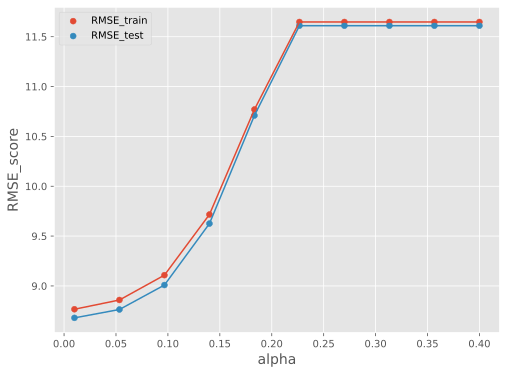

In [206]:
plt.figure(figsize=(8,6))
plt.scatter(alpha,RMSE_train,label='RMSE_train')
plt.plot(alpha,RMSE_train)
plt.scatter(alpha,RMSE_test,label='RMSE_test')
plt.plot(alpha,RMSE_test)
# plt.scatter(alpha,norm,label = 'norm')
# plt.plot(alpha,norm)
# plt.ylim(-0.1,1)
# plt.xlim(0,.43)
plt.xlabel('alpha', size = 14)
plt.ylabel('RMSE_score',size = 14)
plt.legend()
plt.show()

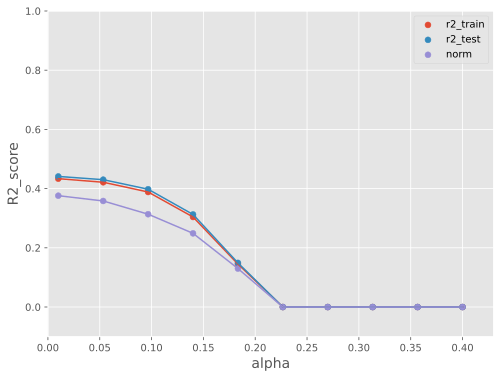

In [207]:
plt.figure(figsize=(8,6))
plt.scatter(alpha,r2_train,label='r2_train')
plt.plot(alpha,r2_train)
plt.scatter(alpha,r2_test,label='r2_test')
plt.plot(alpha,r2_test)
plt.scatter(alpha,norm,label = 'norm')
plt.plot(alpha,norm)
plt.ylim(-0.1,1)
plt.xlim(0,.43)
plt.xlabel('alpha', size = 14)
plt.ylabel('R2_score',size = 14)
plt.legend()
plt.show()

In [ ]:
# LGBM REGRESSOR RESULTS
# 
# cols_traff_only = ['traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']
# RMSE = 10.709416107561104

##hight corr target columns, stats chosen by highest correlation with target

#MV_Traf_2G_d_Mb','MV_Traf_3G_d_Mb','MV_Traf_4G_d_Mb','MV_ARPU','MV_ap_4G_d','MV_ap_innet_out_v','MV_AP_total',
#'non_accum_internet_vol_max_mnt3','gprs_tar_vol_mea_mnt3','data_3g_tar_vol_mea_mnt3','data_3g_tv_cnt_max_mnt1',
# 'content_cnt_mea_mnt3','clc_no_vas_roam_std_mnt3','all_cnt_mea_mnt3','all_clc_mea_mnt3','dpi_duration','dpi_upload',
# 'dpi_download','dpi_events','dpi_day_cnt','target','traff_m5','traff_m3','traff_m2', 'traff_m1']

#RMSE = 10.635576100742853


#withou traffic columns with their STD instead
# RMSE =10.712767746328739

#pca1 and pca2 instead of traffic columns

#RMSE = 10.647630252841243


In [208]:
model = ltb.LGBMRegressor()

parameters = {'n_estimators':[30, 50, 70, 100, 150], 
              'max_depth':[4, 6, 8, 10], 
              'boosting_type': ['gbdt'],
              'objective': ['regression'],
              'is_unbalance': [True], 
              'random_state': [10], 
              'num_leaves': [30],
              'feature_fraction':[0.5],
              'bagging_fraction': [0.8], 
              'bagging_freq':[15],
              'learning_rate':[0.01]}


from sklearn.metrics import make_scorer
score_func = make_scorer(mean_squared_error, squared=False)


grid_search = GridSearchCV(model, parameters, verbose=1, scoring=score_func, n_jobs=-1)
res = grid_search.fit(X_train_full, y_train_full)

res



Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.6s finished


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15


GridSearchCV(estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [15],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.5],
                         'is_unbalance': [True], 'learning_rate': [0.01],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [30, 50, 70, 100, 150],
                         'num_leaves': [30], 'objective': ['regression'],
                         'random_state': [10]},
             scoring=make_scorer(mean_squared_error, squared=False), verbose=1)

In [209]:
print(f'Best score: {grid_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')

Best score: 10.49079370152776 

Best parameters set:
	bagging_fraction:  0.8
	bagging_freq:  15
	boosting_type:  gbdt
	feature_fraction:  0.5
	is_unbalance:  True
	learning_rate:  0.01
	max_depth:  4
	n_estimators:  30
	num_leaves:  30
	objective:  regression
	random_state:  10


In [211]:
predictions = grid_search.predict(X_test_full)



In [212]:
mean_squared_error(y_test_full, predictions, squared=False)

10.452160232431162

In [217]:
X_train_full.columns

Index(['traff_m1', 'traff_m2', 'traff_m3', 'traff_m5', 'var_quant',
       'dpi_day_cnt', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt1',
       'all_cnt_mea_mnt3', 'all_clc_std_mnt3', 'data_3g_tar_vol_std_mnt3',
       'non_accum_internet_vol_std_mnt3', 'gprs_tar_vol_std_mnt3',
       'MV_ap_innet_out_v', 'MV_Traf_2G_d_Mb', 'MV_Traf_3G_d_Mb',
       'MV_Traf_4G_d_Mb', 'pca1', 'pca2', 'pca3'],
      dtype='object')

In [148]:
model = ltb.LGBMRegressor(objective='regression',random_state=0)

model.fit(X_train_full,y_train_full)
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)
y_test_test_pred = model.predict(X_test_test_full)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False), 
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



RMSE train: 7.985060, test: 8.567211, test_test: 8.164066
R^2 train: 0.530019, test: 0.455497, test_test:0.507764


In [172]:
X_list, y_list = [], []
df_list = []

coeff = []

for g, v in data_train_model.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
#Adding data with 90th qauntile by traffic variance

X_list.append(data_train_model_varQ90.loc[:, data_train_model_varQ90.columns != 'target'])
y_list.append(data_train_model_varQ90.target)  


for i, j in zip(X_list, y_list):
    df_list.append(train_test_split(i, j, test_size=0.30, train_size = 0.70, random_state = 13))
    

y_train_pred, y_test_pred, y_train, y_test = pd.Series(), pd.Series(), pd.Series(), pd.Series()

for X_tr, X_ts, y_tr, y_ts in df_list:
    model = ltb.LGBMRegressor(objective='regression',random_state=0)

    model.fit(X_tr, y_tr)
    train_pred = pd.Series(data = model.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)
#     print(y_train_pred.shape)
    
    test_pred = pd.Series(data = model.predict(X_ts), index=y_ts.index)
    y_test_pred = y_test_pred.append(test_pred)
    
    y_train = y_train.append(y_tr)
    y_test = y_test.append(y_ts) 
    
    print(str(X_tr['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_tr, train_pred, squared = False),
        mean_squared_error(y_ts, test_pred, squared = False)))
    print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_tr, train_pred),
        r2_score(y_ts, test_pred)))
    print()
    
    coeff.append(slr.coef_)    
    
    joblib_file = "joblib_model_ltb"+"_q"+str(int(X_tr['var_quant'].unique()[0]))+".pkl"
    joblib.dump(model, joblib_file)

print('RMSE train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
mean_squared_error(y_train, y_train_pred, squared = False),
mean_squared_error(y_test, y_test_pred, squared = False)))  

print('R^2 train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
        

0.0 quantile set results

RMSE train: 1.306261, test: 1.920867
R^2 train: 0.455356, test: -0.026409

1.0 quantile set results

RMSE train: 1.563574, test: 1.882884
R^2 train: 0.444584, test: 0.026067

2.0 quantile set results

RMSE train: 2.187806, test: 2.472059
R^2 train: 0.450969, test: 0.052683

3.0 quantile set results

RMSE train: 2.203167, test: 3.242066
R^2 train: 0.497486, test: 0.172454

4.0 quantile set results

RMSE train: 3.053187, test: 3.678153
R^2 train: 0.489515, test: 0.227691

5.0 quantile set results

RMSE train: 3.932862, test: 4.857356
R^2 train: 0.516677, test: 0.272441

6.0 quantile set results

RMSE train: 5.053546, test: 5.930901
R^2 train: 0.552164, test: 0.299650

7.0 quantile set results

RMSE train: 6.835536, test: 8.502957
R^2 train: 0.554462, test: 0.345454

8.0 quantile set results

RMSE train: 10.066230, test: 12.211484
R^2 train: 0.553923, test: 0.334665

9.0 quantile set results

RMSE train: 16.763873, test: 19.980489
R^2 train: 0.492901, test: 0.265

In [164]:
X_list[9].shape

(25002, 53)

In [173]:
X_list, y_list = [], []
df_list = []


for g, v in data_test_model.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
X_list.append(data_test_model_varQ90.loc[:, data_test_model_varQ90.columns != 'target'])
y_list.append(data_test_model_varQ90.target) 
    
for i, j in zip(X_list, y_list):
    df_list.append([i,j])
    
y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in df_list:
    
    joblib_file = "joblib_model_ltb"+"_q"+str(int(X_ts['var_quant'].unique()[0]))+".pkl"
    model = joblib.load(joblib_file)
#     print(joblib_file)
    
#     print(X_ts.shape)
#     print(model.n_features_)

    test_test_pred = pd.Series(data = model.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    
    print()
    print(str(X_ts['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 train: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))
   
    y_test_test = y_test_test.append(y_ts) 
   
print()
print('RMSE test TOTAL: {:.6f}'.format(mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test TOTAL: {:.6f}'.format(r2_score(y_test_test, y_test_test_pred)))
    
   


0.0 quantile set results

RMSE test: 1.763459
R^2 train: -0.074908

1.0 quantile set results

RMSE test: 2.218341
R^2 train: 0.007848

2.0 quantile set results

RMSE test: 2.500112
R^2 train: 0.043140

3.0 quantile set results

RMSE test: 3.402919
R^2 train: 0.152445

4.0 quantile set results

RMSE test: 4.411784
R^2 train: 0.179399

5.0 quantile set results

RMSE test: 5.118461
R^2 train: 0.239840

6.0 quantile set results

RMSE test: 6.590547
R^2 train: 0.273914

7.0 quantile set results

RMSE test: 9.161122
R^2 train: 0.285006

8.0 quantile set results

RMSE test: 12.876422
R^2 train: 0.290142

9.0 quantile set results

RMSE test: 20.246305
R^2 train: 0.192718

RMSE test TOTAL: 8.801185
R^2 test TOTAL: 0.427938


In [137]:
import lightgbm as lgb

params = {'verbose': -1}

lgb_train = lgb.Dataset(X_train_full, y_train_full, params=params, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test_full, y_test_full, params=params, free_raw_data=False)
init_gbm = lgb.train(params, lgb_eval)
gbm = lgb.train(params, lgb_train,
#                 valid_sets=lgb_eval,
                verbose_eval=False,
                init_model=init_gbm)

In [144]:
gbm.feature_importance

<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x000001E85FB1AE50>>

In [ ]:
#closs_val_score(model, X, y ... )
#from skearn.model_selection import GridSearchCV

In [ ]:
start = timer()

# Fit the model to the training data
y_kmeans = kmeans.fit_predict(X)

end = timer()
print(timedelta(seconds=end-start))

In [112]:
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y_train, y_pred):
    return mean_squared_error(y_train, y_pred, squared=False)



# If you only want to calculate the mean_squared_error you can use mean_squared_error only. 
# But if you want to use it to tune your models, or cross_validate using the utilities present in Scikit, 
# use 'neg_mean_squared_error'.

In [113]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
# from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

In [134]:

lasso = Lasso(alpha =0.0005, random_state=0, normalize = True)
elasticNet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=0, normalize = True)
# kernelRidge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
# svr = SVR(C= 20, epsilon= 0.008, gamma=0.0003)
gradientBoosting = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =0)
xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =0, nthread = -1)
lgbm = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, random_state=0, verbose = 0)
randomForest = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=0)

In [115]:
scores ={}

In [119]:
score = rmsle_cv(lasso)
print("Lasso:: Mean:",score.mean(), " Std:", score.std())
scores['lasso'] = (score.mean(), score.std())
lasso_model = lasso.fit(X_train_full, y_train_full)
y_pred_lasso = lasso_model.predict(X_train_full)
rmsle(y_train_full,y_pred_lasso)

Lasso:: Mean: 5.931878926293097  Std: 0.13247450646938316


8.763426

In [120]:
score = rmsle_cv(elasticNet)
print("ElasticNet:: Mean:",score.mean(), " Std:", score.std())
scores['elasticNet'] = (score.mean(), score.std())
elasticNet_model = elasticNet.fit(X_train_full, y_train_full)
y_pred_elasticNet = elasticNet_model.predict(X_train_full)
rmsle(y_train_full,y_pred_elasticNet)

ElasticNet:: Mean: 6.7654107628992985  Std: 0.1370853914858492


9.936368

In [237]:
# score = rmsle_cv(kernelRidge)
# print("KernelRidge:: Mean:",score.mean(), " Std:", score.std())
# scores['kernelRidge'] = (score.mean(), score.std())
# kernelRidge_model = kernelRidge.fit(X_train_full, y_train_full)
# y_pred_kernelRidge = kernelRidge_model.predict(X_train_full)
# rmsle(y_train_full,y_pred_kernelRidge)

In [ ]:
# score = rmsle_cv(svr)
# print("SVR:: Mean:",score.mean(), " Std:", score.std())
# scores['svr'] = (score.mean(), score.std())
# svr_model = svr.fit(X_train_full, y_train_full)
# y_pred_svr = svr_model.predict(X_train_full)
# rmsle(y_train_full,y_pred_svr)

In [ ]:
# score = rmsle_cv(gradientBoosting)
# print("GradientBoostingRegressor:: Mean:",score.mean(), " Std:", score.std())
# scores['gradientBoosting'] = (score.mean(), score.std())
# gradientBoosting_model = gradientBoosting.fit(X_train_full, y_train_full)
# y_pred_gradientBoosting = gradientBoosting_model.predict(X_train_full)
# rmsle(y_train_full,y_pred_gradientBoosting)

In [ ]:
score = rmsle_cv(xgb)
print("XGBRegressor:: Mean:",score.mean(), " Std:", score.std())
scores['xgb'] = (score.mean(), score.std())
xgb_model = xgb.fit(X_train_full, y_train_full)
y_pred_xgb = xgb_model.predict(X_train_full)
rmsle(y_train_full,y_pred_xgb)

In [135]:
score = rmsle_cv(lgbm)
print("LGBMRegressor:: Mean:",score.mean(), " Std:", score.std())
scores['lgbm'] = (score.mean(), score.std())
lgbm_model = lgbm.fit(X_train_full, y_train_full)
y_pred_lgbm = lgbm_model.predict(X_train_full)
rmsle(y_train_full,y_pred_lgbm)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

8.46419532735369

In [136]:
score = rmsle_cv(randomForest)
print("RandomForestRegressor:: Mean:",score.mean(), " Std:", score.std())
scores['randomForest'] = (score.mean(), score.std())
randomForest_model = randomForest.fit(X_train_full, y_train_full)
y_pred_randomForest = randomForest_model.predict(X_train_full)
rmsle(y_train_full,y_pred_randomForest)

KeyboardInterrupt: 

In [ ]:

def ensemble_models(X):
    return ((0.1 * lasso_model.predict(X)) +
            (0.1 * elasticNet_model.predict(X)) +
#            (0.1 * kernelRidge_model.predict(X)) +
#            (0.4 * gradientBoosting_model.predict(X)) + 
           (0.1 * xgb_model.predict(X)) +
           (0.2 * lgbm_model.predict(X)))

In [ ]:

averaged_score = rmsle(y_train_full, ensemble_models(X_train_full))
scores['averaged'] = (averaged_score, 0)
print('RMSLE score on train data:', averaged_score)

In [ ]:
sns.set_style("white")
fig = plt.figure(figsize=(20, 10))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)
plt.title('Scores of Models', size=20)
plt.show()